## COVID19 CT Pneumonia Detection - Multiclass Case
By Adrian Yijie Xu
(https://medium.com/@adrianitsaxu)

As discussed in "Detecting COVID-19 induced Pneumonia from Chest X-rays with Transfer Learning: An implementation in Tensorflow and Keras."
(https://github.com/EXJUSTICE/GradientCrescent)

50% test accuracy with 4 classes
100% test accuracy with 3 classes

Conclusion: Viral Pneumonia indistinguishable from COVID19: acceptable, given that COVID19 is itself caused by viral means.



In [1]:
!pip install opendatasets
import opendatasets as od
import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

os.environ['PYTHONHASHSEED'] = '73'

seed = 73
random.seed(seed)
np.random.seed(seed)

print(platform.platform())
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic


In [3]:
od.download("https://www.kaggle.com/datasets/andyczhao/covidx-cxr2")
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

Skipping, found downloaded files in "./covidx-cxr2" (use force=True to force download)
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dylanmarkovic
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [01:42<00:00, 24.0MB/s]


In [4]:
DataDir = './covidx-cxr2'
PneumoniaDir = './chest-xray-pneumonia/chest_xray'

print('> Covid 19 dir:', os.listdir(DataDir))
print('> Pneumonia dir:', os.listdir(PneumoniaDir))

> Covid 19 dir: ['test.txt', 'train.txt', 'train', 'test']
> Pneumonia dir: ['__MACOSX', 'train', 'test', 'val', 'chest_xray']


In [5]:
from tqdm import tqdm

train_image_dir = PneumoniaDir + '/train'
test_image_dir = PneumoniaDir + '/test'
val_image_dir = PneumoniaDir + '/val'

img_map = []

def prepareData(Dir, strat):
    cats = ["NORMAL","PNEUMONIA"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(train_image_dir,'train')
prepareData(test_image_dir,'test')
prepareData(val_image_dir, 'val')

img_map = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 8/8 [00:00<00:00, 22779.66it/s]


In [6]:
#ricord, rsna, cohen, actmed, sirm, 
def getClass(label):
    if label == 'negative':
        return 'NORMAL'
    if label == 'positive':
        return 'COVID'

def get_image_map(txt_path, strat):
    train_txt = open(txt_path, 'r')
    Lines = train_txt.readlines()
    paths = []
    
    img_formats = ['jpg', 'jpeg', 'png']
    
    for n, line in enumerate(Lines):
        querywords = line.split()

        if len(querywords) == 4:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[1]
            label = querywords[2]

        if len(querywords) == 5:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[2]
            label = querywords[3]
            
        for img_type in img_formats:
            if img_type in line:
                obj_ = {'path': image_path, 'label': getClass(label)}
                if (('positive' in line) | ('negative' in line)):
                    paths.append(obj_)

    paths_df = pd.DataFrame(paths)
    return paths_df

In [7]:
train_map = get_image_map(DataDir + '/train.txt', 
                          strat='train').sample(frac = 1, random_state=73)

test_map = get_image_map(DataDir + '/test.txt',
                         strat='test').sample(frac = 1, random_state=73)

In [9]:
img_path_map = pd.concat([img_map, train_map, test_map], axis=0).sample(frac = 1, random_state=73)
img_path_map.head()

,path,label
1222,./covidx-cxr2/train/COVID(519).png,COVID
2940,./covidx-cxr2/train/171648d9-c749-4146-8e2e-2a...,NORMAL
22928,./covidx-cxr2/train/A046441-11-10-1900-NA-CHES...,COVID
24207,./covidx-cxr2/train/A806933-12-31-1900-NA-CHES...,COVID
27029,./covidx-cxr2/train/A014950-01-01-1901-NA-CHES...,COVID


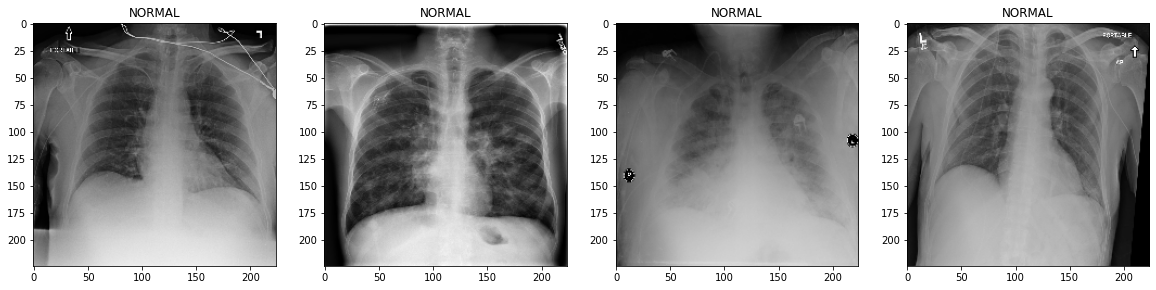

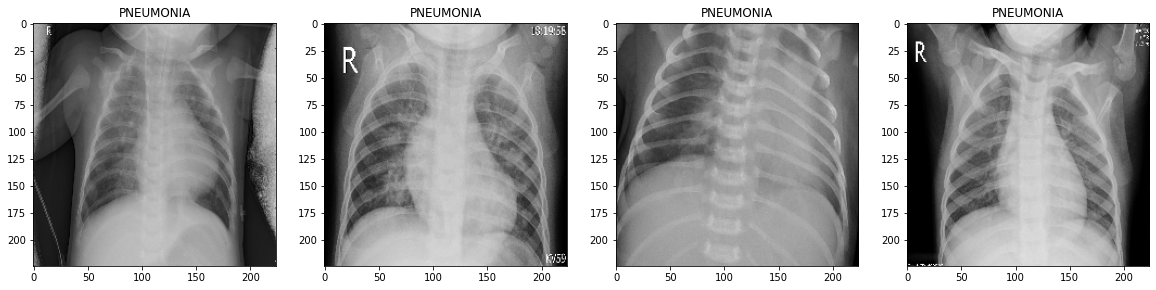

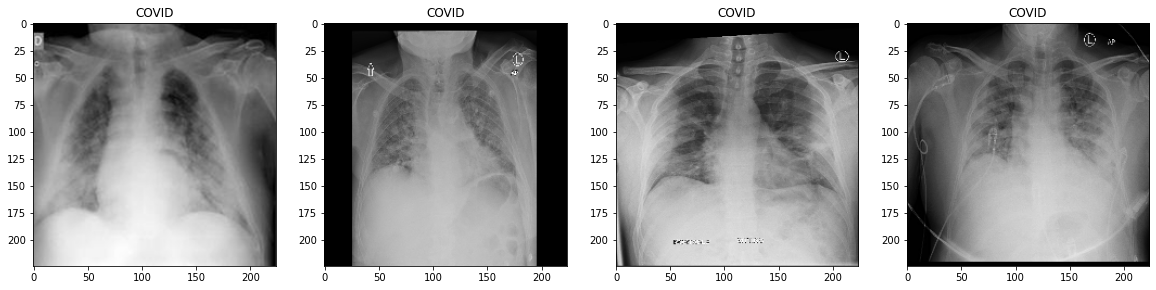

In [10]:
import matplotlib.pyplot as plt

def print_images(samples): 
    images = samples["path"].to_numpy()
    labels = samples['label'].to_numpy()
    
    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(labels[i])
        
        Sample_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
        
        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)
        
    plt.show()
        
print_images(img_path_map[img_path_map['label']=="NORMAL"].iloc[0:4])
print_images(img_path_map[img_path_map['label']=="PNEUMONIA"].iloc[0:4])
print_images(img_path_map[img_path_map['label']=="COVID"].iloc[0:4])

%matplotlib inline

In [11]:
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(img_path_map)
print(label_count)

COVID        16194
NORMAL       15773
PNEUMONIA     4273
dtype: int64


In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

features = img_path_map['path'].to_numpy()
labels = img_path_map['label'].to_numpy()

stratified_sample = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=73)

In [13]:
for train_index, test_index in stratified_sample.split(features, labels):
    X_train, test_X = features[train_index], features[test_index]
    y_train, test_y = labels[train_index], labels[test_index]
    
half_size = np.int(len(test_X) / 2)
X_test, y_test = test_X[0:half_size], test_y[0:half_size]
X_val, y_val = test_X[half_size:], test_y[half_size:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [14]:
train_map = pd.DataFrame()
train_map['path'], train_map['label'] = X_train, y_train

In [15]:
test_map = pd.DataFrame()
test_map['path'], test_map['label'] = X_test, y_test

In [16]:
val_map = pd.DataFrame()
val_map['path'], val_map['label'] = X_val, y_val

In [17]:
# data summary
print('> {} train size'.format(X_train.shape[0]))
print('> {} test size'.format(X_test.shape[0]))
print('> {} val size'.format(X_val.shape[0]))

> 28992 train size
> 3624 test size
> 3624 val size


In [18]:
import cv2
import time
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
ia.seed(73)

ColorCh = 3
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, ColorCh)

classes = ("COVID", "NORMAL","PNEUMONIA")
CATEGORIES = sorted(classes)

print('> Classes:',CATEGORIES)

> Classes: ['COVID', 'NORMAL', 'PNEUMONIA']


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import img_to_array

datagen = ImageDataGenerator(rescale = 1./255, 
                             horizontal_flip=True,
                             brightness_range=[1.0,1.3],
                             rotation_range=15,
                             #zoom_range=0.2
                            )

In [24]:
batch_size = 64

def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="sparse",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)             
             )
    
    return generator

In [25]:
train_df = train_map.sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

print('> label count for train set')
getLabelCount(train_df)

Found 28992 validated image filenames belonging to 3 classes.
> label count for train set


COVID        12955
NORMAL       12619
PNEUMONIA     3418
dtype: int64

In [26]:
test_df = test_map.sample(frac=1, random_state=seed)
test_generator = get_generator(test_df)

print('> label count for test set')
getLabelCount(test_df)

Found 3624 validated image filenames belonging to 3 classes.
> label count for test set


COVID        1628
NORMAL       1574
PNEUMONIA     422
dtype: int64

In [27]:
val_df = val_map.sample(frac=1, random_state=seed)
val_generator = get_generator(val_df)

print('> label count for val set')
getLabelCount(val_df)

Found 3624 validated image filenames belonging to 3 classes.
> label count for val set


COVID        1611
NORMAL       1580
PNEUMONIA     433
dtype: int64

In [28]:
print('> input shape:', input_shape)

> input shape: (224, 224, 3)


In [29]:
n_classes = len(CATEGORIES)

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive')

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#set randomness for reproducibility
import os
from numpy.random import seed
seed(8) #1
#from tensorflow import set_random_seed
import tensorflow as tf
tf.random.set_seed(7) #2

#

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os


basePath = "/content/drive/MyDrive/Colab Notebooks/COVID19_Detection_Transfer_Learning_VGG16/"
covDataPath = basePath+'Covid_Data_GradientCrescent'
#!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
#!unzip Covid_Data_GradientCrescent.zip
#!unzip covDataPath
print(basePath)
print(covDataPath)
'''




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/COVID19_Detection_Transfer_Learning_VGG16/
/content/drive/MyDrive/Colab Notebooks/COVID19_Detection_Transfer_Learning_VGG16/Covid_Data_GradientCrescent


In [ ]:
'''
print(os.listdir(basePath))
print(os.listdir(covDataPath))
#Print and remove zips once done

#!rm Covid_Data_GradientCrescent.zip
'''


['Covid19_GradientCrescent_Multi.ipynb', 'covid_3class.png', 'covid_4class.png', 'README.md', 'covid_binary.png', 'Covid19_GradientCrescent_Binary.ipynb', 'covidcomparison.png', '.git', 'Covid_Data_GradientCrescent']
['all', 'two']


In [ ]:
#Enable this cell to remove viral pneumonia class. Remember to Change model's final layer to 3 neurons.
'''
!rm -rf /content/drive/MyDrive/Colab Notebooks/COVID19_Detection_Transfer_Learning_VGG16/Covid_Data_GradientCrescent/all/test/pneumonia_vir

!rm -rf /content/drive/MyDrive/Colab Notebooks/COVID19_Detection_Transfer_Learning_VGG16/Covid_Data_GradientCrescent/all/train/pneumonia_vir
'''

In [ ]:
'''from os import listdir
data_list = listdir(covDataPath+'/all/train')

#Delete some classes that may interfere


data_list
'''

['normal', 'covid', 'pneumonia_bac', 'pneumonia_vir']

Case 2: COVID vs Normal vs Tertiary Pneumonia (Bacterial and Viral)
VGG Initialization

In [35]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf


#DATASET_PATH  = covDataPath+'/all/train'
#test_dir =  covDataPath+'/all/test'
IMAGE_SIZE    = input_shape
NUM_CLASSES   = n_classes
BATCH_SIZE    = 64  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE =0.0001



#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_dataframe(train_df,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="categorical",
                                                  x_col="path",
                                                  y_col="label"
                                                  )

valid_batches = train_datagen.flow_from_dataframe(val_df,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="categorical",
                                                  x_col="path",
                                                  y_col="label"
                                                 
                                                  )



Found 23194 validated image filenames belonging to 3 classes.
Found 724 validated image filenames belonging to 3 classes.


Layer Modification at upper layer of VGG16

In [41]:
#Simple CNN model based on VGG16. Set dense layer neuron count to 3 if viral pneumonia class is removed


from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=IMAGE_SIZE)


conv_base.trainable = False


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [42]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [45]:
batch_size = 64

def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="categorical",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)             
             )
    
    return generator

In [46]:
train_df = train_map.sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

print('> label count for train set')
getLabelCount(train_df)

Found 28992 validated image filenames belonging to 3 classes.
> label count for train set


COVID        12955
NORMAL       12619
PNEUMONIA     3418
dtype: int64

In [47]:
test_df = test_map.sample(frac=1, random_state=seed)
test_generator = get_generator(test_df)

print('> label count for test set')
getLabelCount(test_df)

Found 3624 validated image filenames belonging to 3 classes.
> label count for test set


COVID        1628
NORMAL       1574
PNEUMONIA     422
dtype: int64

In [48]:
val_df = val_map.sample(frac=1, random_state=seed)
val_generator = get_generator(val_df)

print('> label count for val set')
getLabelCount(val_df)

Found 3624 validated image filenames belonging to 3 classes.
> label count for val set


COVID        1611
NORMAL       1580
PNEUMONIA     433
dtype: int64

Training

In [54]:
#FIT MODEL
def FitModel(model, name):
    history = model.fit(train_generator, 
                        epochs=13,
                        validation_data = val_generator,
                        steps_per_epoch=(len(train_generator.labels) / 80),
                        validation_steps=(len(val_generator.labels) / 80),
                       )
    
    model.load_weights(name + '_Weights.h5')

    final_accuracy_avg = np.mean(history.history[getMetrics(name, "val_accuracy")][-5:])

    final_loss = history.history[getMetrics(name, "val_loss")][-1]
  
    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss: 'loss'}

    print('\n')
    print('---'*15)
    print(name,' Model')
    print('Total Epochs :', len(history.history[getMetrics(name, 'loss')]))    
    print('Restoring best Weights')
    
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('---'*15)
    print('Best Epoch :', index)
    print('---'*15)
    
    train_accuracy = history.history[getMetrics(name, 'accuracy')][index]
    train_loss = history.history[getMetrics(name, 'loss')][index]
    
    val_accuracy = history.history[getMetrics(name, 'val_accuracy')][index]
    val_loss = history.history[getMetrics(name, 'val_loss')][index]

    print('Accuracy on train:', train_accuracy,
          '\tLoss on train:', train_loss)
    
    print('Accuracy on val:', val_accuracy ,
          '\tLoss on val:', val_loss)
    print('---'*15)

    return model, history
vModel, vHistory = FitModel(model, 'VGG16')

NameError: ignored

Evaluation

In [71]:
print(model.__dict__)
print(model.history.__dict__)
print(model.history.history)
name = 'VGG16'
final_accuracy_avg = np.mean(model.history.history["val_acc"][-5:])

final_loss = model.history.history["val_loss"][-1]

#group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss: 'loss'}

print('\n')
print('---'*15)
print(name,' Model')
print('Total Epochs :', len(model.history.history['loss']))    
print('Restoring best Weights')

index = (len(model.history.history['loss']) - (1))
print('---'*15)
print('Best Epoch :', index)
print('---'*15)

train_accuracy = model.history.history['acc'][index]
train_loss = model.history.history['loss'][index]

val_accuracy = model.history.history['val_acc'][index]
val_loss = model.history.history['val_loss'][index]

print('Accuracy on train:', train_accuracy,
      '\tLoss on train:', train_loss)

print('Accuracy on val:', val_accuracy ,
      '\tLoss on val:', val_loss)
print('---'*15)

{'_self_setattr_tracking': True, '_is_model_for_instrumentation': True, '_instrumented_keras_api': True, '_instrumented_keras_layer_class': False, '_instrumented_keras_model_class': True, '_trainable': True, '_stateful': False, 'built': True, '_input_spec': None, '_build_input_shape': TensorShape([None, 224, 224, 3]), '_saved_model_inputs_spec': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='vgg16_input'), '_saved_model_arg_spec': ([TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='vgg16_input')], {}), '_supports_masking': True, '_name': 'sequential_2', '_activity_regularizer': None, '_trainable_weights': [], '_non_trainable_weights': [], '_updates': [], '_thread_local': <_thread._local object at 0x7ff864376fb0>, '_callable_losses': [], '_losses': [], '_metrics': [], '_metrics_lock': <unlocked _thread.lock object at 0x7ff8c00efe70>, '_dtype_policy': <Policy "float32">, '_compute_dtype_object': tf.float32, '_autocast': False, '_self_tracked_trackables': [<kera

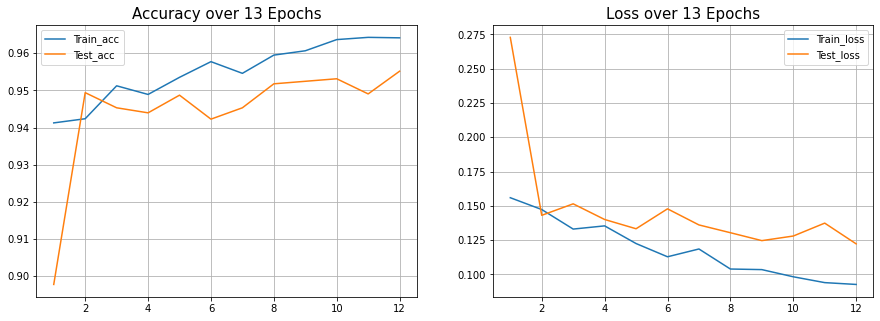

In [73]:
import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(model.history, 13)

In [ ]:
model.save('Covid_Multi.h5')

Predict

In [ ]:

#Dont forget shuffle false
#See https://github.com/keras-team/keras/issues/6499
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=True,
        seed=42,
        
        class_mode="categorical")
eval_generator.reset()    


Found 36 images belonging to 4 classes.


In [ ]:

eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

#Poor test accuracy due to the small dataset size

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


4/4 [==============================] - 3s 667ms/step - loss: 2.4180 - acc: 0.5000
Test loss: 2.4180142879486084
Test accuracy: 0.5


Optional: Finetuning with a learning rate of 5E-5

In [ ]:

model.compile(loss='categorical_crossentropy',
              
              optimizer=optimizers.Adam(lr=5e-5),
              metrics=['acc'])

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= 20,                        
                       )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
21/21 [==============================] - 7s 308ms/step - loss: 0.4893 - acc: 0.8204 - val_loss: 0.7417 - val_acc: 0.5800
Epoch 2/20
21/21 [==============================] - 6s 281ms/step - loss: 0.5076 - acc: 0.7913 - val_loss: 0.6538 - val_acc: 0.6400
Epoch 3/20
21/21 [==============================] - 6s 284ms/step - loss: 0.4530 - acc: 0.8204 - val_loss: 0.8631 - val_acc: 0.6600
Epoch 4/20
21/21 [==============================] - 6s 287ms/step - loss: 0.4609 - acc: 0.8301 - val_loss: 0.7725 - val_acc: 0.6200
Epoch 5/20
21/21 [==============================] - 6s 289ms/step - loss: 0.5337 - acc: 0.7670 - val_loss: 0.9598 - val_acc: 0.6600
Epoch 6/20
21/21 [==============================] - 6s 283ms/step - loss: 0.4464 - acc: 0.8048 - val_loss: 0.6272 - val_acc: 0.7200
Epoch 7/20
21/21 [==============================] - 6s 287ms/step - loss: 0.4351 - acc: 0.8301 - val_loss: 0.6487 - val_acc: 0.7000
Epoch 8/20
21/21 [==============================] - 8s 381ms/step - loss: 0.

In [ ]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])


3/3 [==============================] - 0s 36ms/step
Test loss: 0.021353596743817132
Test accuracy: 1.0


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
